# Evaluating the Embedder without methods to improve distance measures

Here we analyze the embedding quality of the resolver utterance embedding. Furthermore, we show how some postprocessing methods affect the embeddings. Here also cosine similarity heatmaps are made to see whether using this similarity metric is useful.

In [1]:
import numpy as np
import pandas as pd

import copy
import tensorflow as tf

2022-08-31 02:56:32.071319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 02:56:32.071360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Initialize Embedder

In [2]:
from src.candidate_resolver.embedding.BertEmbedder import BertEmbedder

In [3]:
embedder = BertEmbedder.initialize("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", "https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/4")

2022-08-31 02:56:34.684943: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-31 02:56:34.684975: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-31 02:56:34.684998: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (WorkPad): /proc/driver/nvidia/version does not exist
2022-08-31 02:56:34.685232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-31 02:57:01.193231: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 125018112 exceeds 1

## Load the candidate resolver data

In [4]:
def read_initial_dataset_from(csv_file):
    return pd.read_csv(csv_file, sep=";", dtype="string")

In [5]:
data = read_initial_dataset_from("../../res/thesis_demonstration_set/training_examples")
data

,Lifted instance,DSL output
0,"Select [,column] [table]","SELECT([,column], [table])"
1,"Take [,column] [table]","SELECT([,column], [table])"
2,"Show [,column] [table]","SELECT([,column], [table])"
3,"Display [,column] [table]","SELECT([,column], [table])"
4,"Delete [,column] [table]","DELETE([,column], [table])"
5,"Remove [,column] [table]","DELETE([,column], [table])"
6,"Erase [,column] [table]","DELETE([,column], [table])"
7,"Add [,column] [table]","ADD([,column], [table])"
8,"Append [,column] [table]","ADD([,column], [table])"
9,Sort [condition],SORT([condition])


## Extract labels and embedd data

In [6]:
labels = np.array(data["DSL output"].unique())
labels

array(['SELECT([,column], [table])', 'DELETE([,column], [table])',
       'ADD([,column], [table])', 'SORT([condition])',
       'FILTER([condition])'], dtype=object)

### Embedding functions

In [7]:
from src.candidate_resolver.embedding.embedder_functions import EmbeddingFunctionProvider

In [8]:
embedder_provider = EmbeddingFunctionProvider(embedder)

In [9]:
from src.candidate_resolver.configurables.resolver_configurable_enums import EmbeddingType

sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.SEQUENCE)
bert_pooled_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.BERT_POOLED)
positionally_encoded_sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.SEQUENCE_POSITIONAL)
max_pooled_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.MAX_POOLED)
avg_pooled_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.AVG_POOLED)
max_pooled_positionally_encoded_sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.MAX_POOLED_POSITIONAL)
avg_pooled_positionally_encoded_sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.AVG_POOLED_POSITIONAL)
summed_quadratic_kernel_sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.SUMMED_QUADRATIC_KERNEL_SEQUENCE)
summed_quadratic_kernel_bert_pooled_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.SUMMED_QUADRATIC_KERNEL_BERT_POOLED)
summed_quadratic_kernel_positionally_encoded_sequence_embedder = embedder_provider\
    .select_embedding_function(EmbeddingType.SUMMED_QUADRATIC_KERNEL_SEQUENCE_POSITIONAL)

### Embedd data

In [10]:
embedded_data = copy.deepcopy(data)
embedded_data["Sequence embedding"] = embedded_data["Lifted instance"]\
    .map(sequence_embedder)
embedded_data["Pooled embedding"] = embedded_data["Lifted instance"]\
    .map(bert_pooled_embedder)
embedded_data["Sequence embedding pos encoded"] = embedded_data["Lifted instance"]\
    .map(positionally_encoded_sequence_embedder)
embedded_data["Max pooled embedding without pos"] = embedded_data["Lifted instance"]\
    .map(max_pooled_embedder)
embedded_data["Avg pooled embedding without pos"] = embedded_data["Lifted instance"]\
    .map(avg_pooled_embedder)
embedded_data["Max pooled embedding with pos"] = embedded_data["Lifted instance"]\
    .map(max_pooled_positionally_encoded_sequence_embedder)
embedded_data["Avg pooled embedding with pos"] = embedded_data["Lifted instance"]\
    .map(avg_pooled_positionally_encoded_sequence_embedder)
embedded_data["Summed quadratic kernel sequence embedding"] = \
    embedded_data["Lifted instance"].map(summed_quadratic_kernel_sequence_embedder)
embedded_data["Summed quadratic kernel sequence embedding with pos"] = \
    embedded_data["Lifted instance"]\
        .map(summed_quadratic_kernel_positionally_encoded_sequence_embedder)
embedded_data["Summed quadratic kernel pooled embedding"] = \
    embedded_data["Lifted instance"].map(summed_quadratic_kernel_bert_pooled_embedder)

In [11]:
embedded_data

,Lifted instance,DSL output,Sequence embedding,Pooled embedding,Sequence embedding pos encoded,Max pooled embedding without pos,Avg pooled embedding without pos,Max pooled embedding with pos,Avg pooled embedding with pos,Summed quadratic kernel sequence embedding,Summed quadratic kernel sequence embedding with pos,Summed quadratic kernel pooled embedding
0,"Select [,column] [table]","SELECT([,column], [table])","(((tf.Tensor(0.14310724, shape=(), dtype=float...","((tf.Tensor(0.94189084, shape=(), dtype=float3...","(((tf.Tensor(0.034067065, shape=(), dtype=floa...","((tf.Tensor(2.130275, shape=(), dtype=float32)...","((tf.Tensor(0.012326387, shape=(), dtype=float...","((tf.Tensor(1.7551742, shape=(), dtype=float32...","((tf.Tensor(0.010527899, shape=(), dtype=float...","(tf.Tensor(3771445.5, shape=(), dtype=float32)...","(tf.Tensor(4503287.0, shape=(), dtype=float32)...","(tf.Tensor(667.687, shape=(), dtype=float32), ..."
1,"Take [,column] [table]","SELECT([,column], [table])","(((tf.Tensor(0.12190775, shape=(), dtype=float...","((tf.Tensor(0.9659887, shape=(), dtype=float32...","(((tf.Tensor(-0.029208668, shape=(), dtype=flo...","((tf.Tensor(2.066711, shape=(), dtype=float32)...","((tf.Tensor(-0.0039918846, shape=(), dtype=flo...","((tf.Tensor(1.6850505, shape=(), dtype=float32...","((tf.Tensor(0.007907193, shape=(), dtype=float...","(tf.Tensor(3806473.0, shape=(), dtype=float32)...","(tf.Tensor(4520641.5, shape=(), dtype=float32)...","(tf.Tensor(699.7842, shape=(), dtype=float32),..."
2,"Show [,column] [table]","SELECT([,column], [table])","(((tf.Tensor(0.103115715, shape=(), dtype=floa...","((tf.Tensor(0.9561712, shape=(), dtype=float32...","(((tf.Tensor(0.0560164, shape=(), dtype=float3...","((tf.Tensor(2.2714014, shape=(), dtype=float32...","((tf.Tensor(0.01551667, shape=(), dtype=float3...","((tf.Tensor(1.7946177, shape=(), dtype=float32...","((tf.Tensor(0.009919982, shape=(), dtype=float...","(tf.Tensor(3782721.5, shape=(), dtype=float32)...","(tf.Tensor(4505320.0, shape=(), dtype=float32)...","(tf.Tensor(693.22473, shape=(), dtype=float32)..."
3,"Display [,column] [table]","SELECT([,column], [table])","(((tf.Tensor(0.057391074, shape=(), dtype=floa...","((tf.Tensor(0.9529924, shape=(), dtype=float32...","(((tf.Tensor(-0.10154192, shape=(), dtype=floa...","((tf.Tensor(2.0757692, shape=(), dtype=float32...","((tf.Tensor(0.0059459168, shape=(), dtype=floa...","((tf.Tensor(1.7831995, shape=(), dtype=float32...","((tf.Tensor(0.009194721, shape=(), dtype=float...","(tf.Tensor(3604978.5, shape=(), dtype=float32)...","(tf.Tensor(4607714.0, shape=(), dtype=float32)...","(tf.Tensor(683.04486, shape=(), dtype=float32)..."
4,"Delete [,column] [table]","DELETE([,column], [table])","(((tf.Tensor(0.18921486, shape=(), dtype=float...","((tf.Tensor(0.86055124, shape=(), dtype=float3...","(((tf.Tensor(-0.008708663, shape=(), dtype=flo...","((tf.Tensor(2.141731, shape=(), dtype=float32)...","((tf.Tensor(-0.019698666, shape=(), dtype=floa...","((tf.Tensor(1.5980523, shape=(), dtype=float32...","((tf.Tensor(0.0063043796, shape=(), dtype=floa...","(tf.Tensor(4233285.0, shape=(), dtype=float32)...","(tf.Tensor(5155118.0, shape=(), dtype=float32)...","(tf.Tensor(553.8817, shape=(), dtype=float32),..."
5,"Remove [,column] [table]","DELETE([,column], [table])","(((tf.Tensor(0.14014623, shape=(), dtype=float...","((tf.Tensor(0.9404374, shape=(), dtype=float32...","(((tf.Tensor(-0.11296007, shape=(), dtype=floa...","((tf.Tensor(1.9586685, shape=(), dtype=float32...","((tf.Tensor(-0.0032230911, shape=(), dtype=flo...","((tf.Tensor(1.717567, shape=(), dtype=float32)...","((tf.Tensor(0.008795554, shape=(), dtype=float...","(tf.Tensor(3910499.0, shape=(), dtype=float32)...","(tf.Tensor(4532213.0, shape=(), dtype=float32)...","(tf.Tensor(654.9575, shape=(), dtype=float32),..."
6,"Erase [,column] [table]","DELETE([,column], [table])","(((tf.Tensor(0.15260263, shape=(), dtype=float...","((tf.Tensor(0.94254184, shape=(), dtype=float3...","(((tf.Tensor(-0.

## Create 3D plots of embedded data

### WARNING: It is not possible to plot all plots coming up due to limitations of matplotlib and tkinter! Only use the cells you want to have a plot of!

In [12]:
from src.plotting.plots import create_three_dimensional_scatter_of
"""
uncomment if you want interactive plots but beware as you cannot print all plots at once
"""
# %matplotlib tk

'\nuncomment if you want interactive plots but beware as you cannot print all plots at once\n'

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


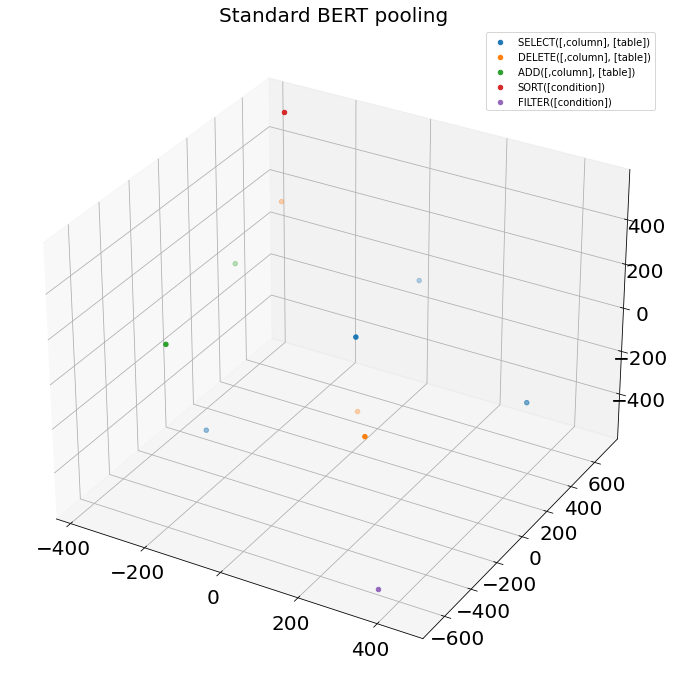

In [13]:
create_three_dimensional_scatter_of(
    "bert_pooled_scatter",
    embedded_data, "Pooled embedding",
    "DSL output", "Standard BERT pooling"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


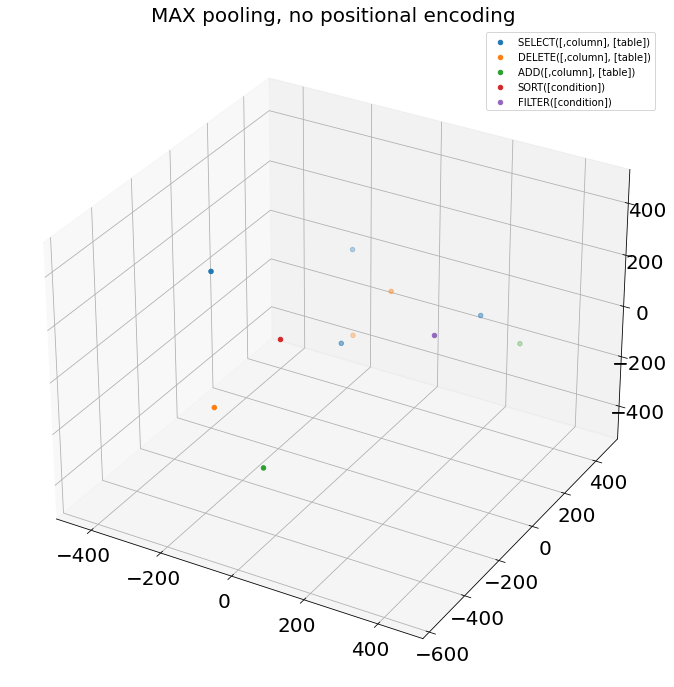

In [14]:
create_three_dimensional_scatter_of(
    "max_pooled_scatter",
    embedded_data, "Max pooled embedding without pos",
    "DSL output", "MAX pooling, no positional encoding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


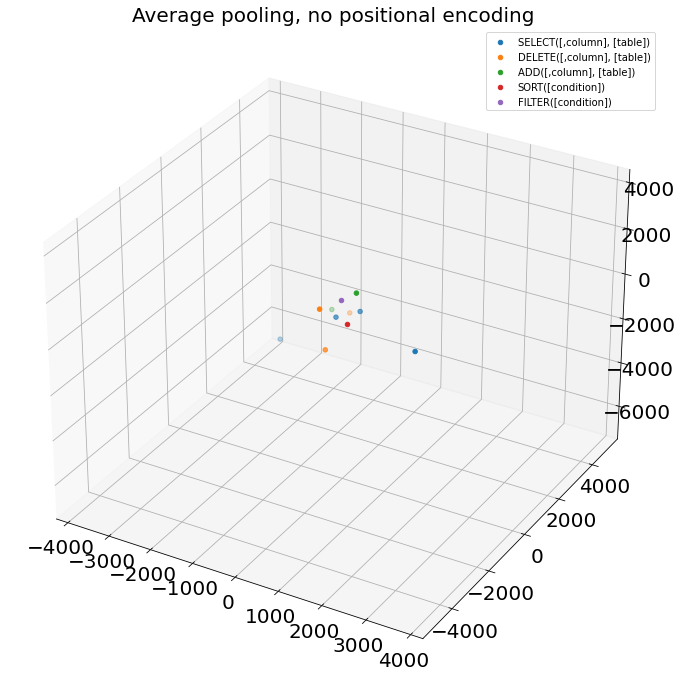

In [15]:
create_three_dimensional_scatter_of(
    "avg_pooled_scatter",
    embedded_data, "Avg pooled embedding without pos",
    "DSL output", "Average pooling, no positional encoding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


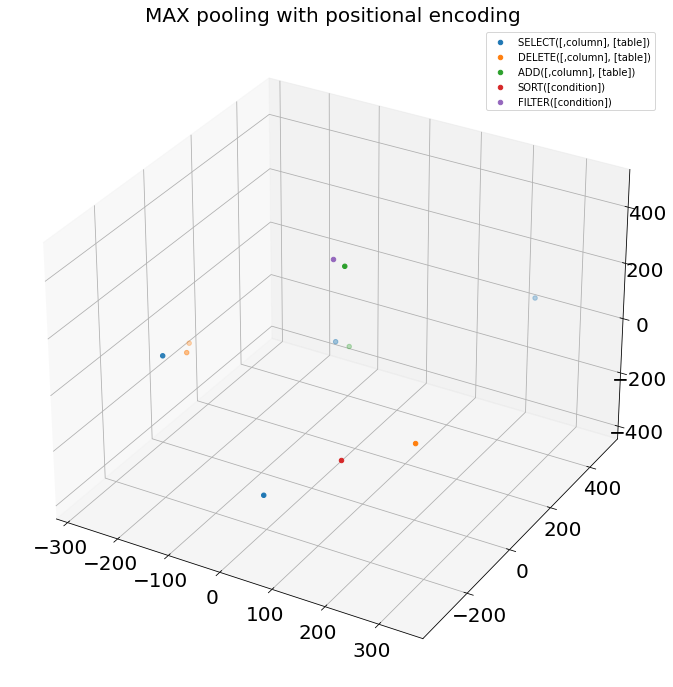

In [16]:
create_three_dimensional_scatter_of(
    "max_pooled_pos_scatter",
    embedded_data, "Max pooled embedding with pos",
    "DSL output", "MAX pooling with positional encoding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


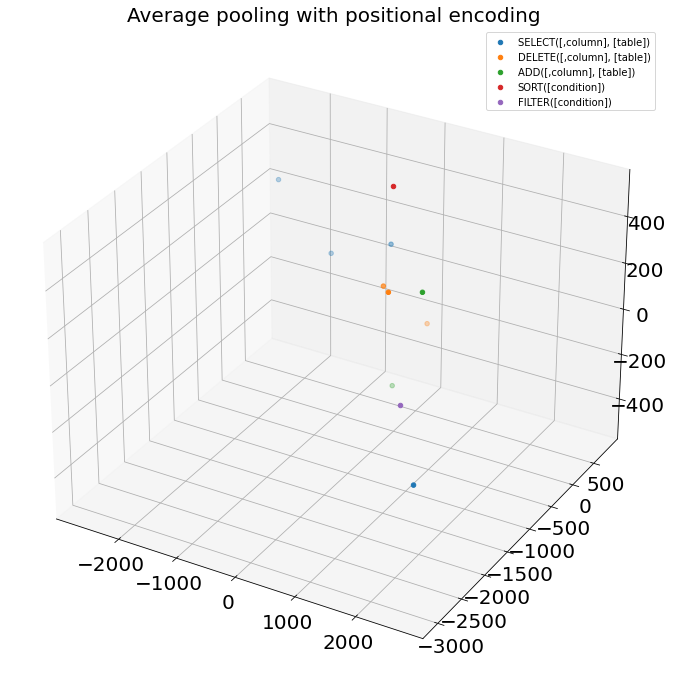

In [17]:
create_three_dimensional_scatter_of(
    "avg_pooled_pos_scatter",
    embedded_data, "Avg pooled embedding with pos",
    "DSL output", "Average pooling with positional encoding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


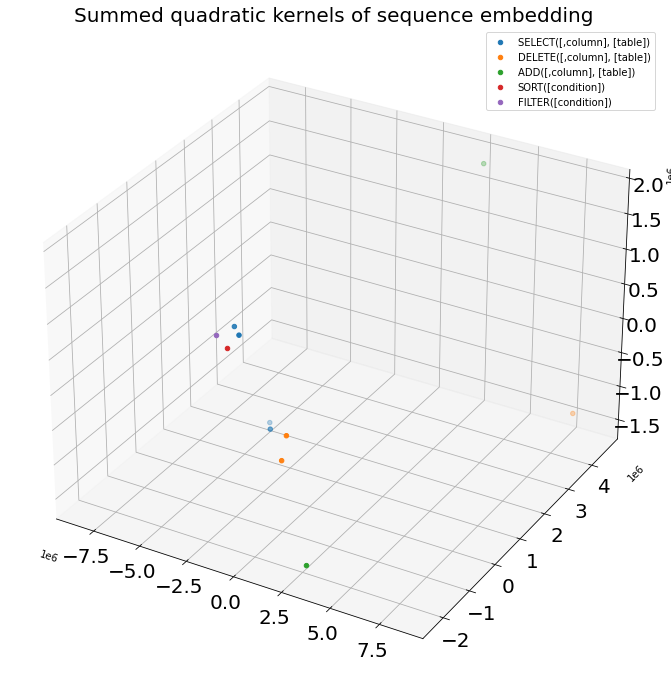

In [18]:
create_three_dimensional_scatter_of(
    "summed_quadratic_scatter",
    embedded_data, "Summed quadratic kernel sequence embedding",
    "DSL output",
    "Summed quadratic kernels of sequence embedding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


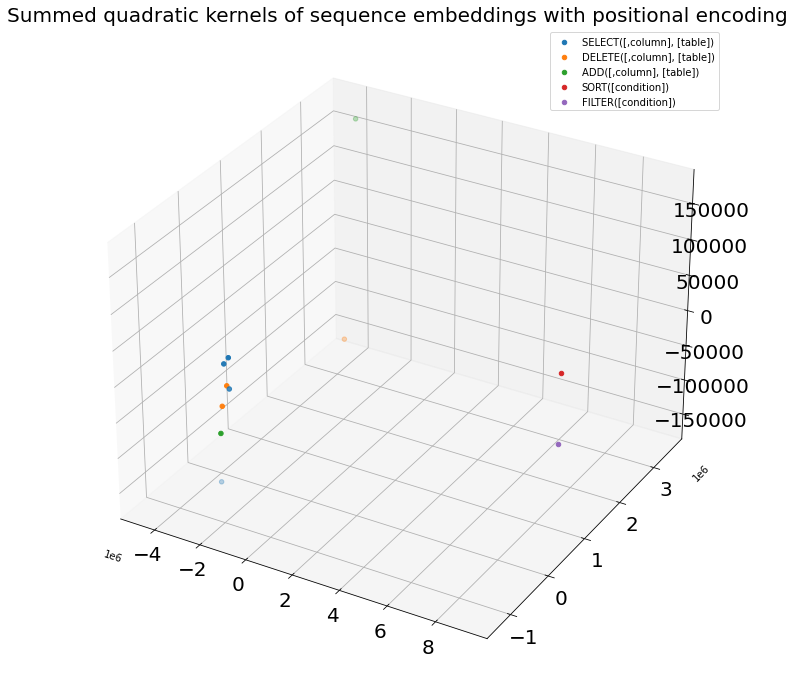

In [19]:
create_three_dimensional_scatter_of(
    "summed_quadratic_pos_scatter",
    embedded_data, "Summed quadratic kernel sequence embedding with pos",
    "DSL output",
    "Summed quadratic kernels of sequence embeddings with positional encoding"
)

/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pandavid/PycharmProjects/EfficientParsing/venv/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


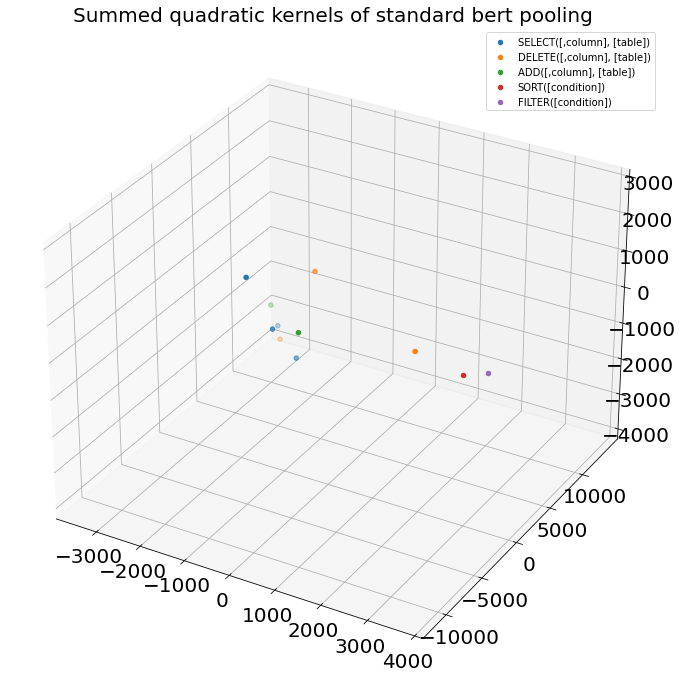

In [20]:
create_three_dimensional_scatter_of(
    "summed_quadratic_pooled_scatter",
    embedded_data, "Summed quadratic kernel pooled embedding",
    "DSL output",
    "Summed quadratic kernels of standard bert pooling"
)

## Create cosine similarity heatmaps of classes

One can see below that the example vectors used here are very similar according to cosine similarity.

In [21]:
from typing import List
from src.candidate_resolver.embedding.embedding_utils import compute_cosine_similarities

In [22]:
def get_all_vectors_by_classes(data: pd.DataFrame, input_column_names: List[str], output_column_names: List[str]):
    if len(input_column_names) != len(output_column_names):
        raise ValueError(
            "The number of output and input column names must be the same.\n" +
            f"Number of input column names {len(input_column_names)}, number of output column names {len(output_column_names)}"
        )

    result_dataframe = pd.DataFrame()
    result_dataframe["class"] = data["DSL output"].unique()
    for i, input_column_name in enumerate(input_column_names):
        vectors = get_all_vectors_by_class(data, input_column_name)
        result_dataframe[output_column_names[i]] = vectors
    return result_dataframe

def get_all_vectors_by_class(data: pd.DataFrame, input_column_name: str):
    vectors = []
    for cls in data["DSL output"].unique():
        class_entries = data.loc[data["DSL output"] == cls]
        class_vectors = np.stack(class_entries[input_column_name].to_numpy())
        vectors.append(
            class_vectors[:, 0, :] if len(class_vectors.shape) > 2 else class_vectors
        )
    return vectors

In [23]:
class_aligned_data = get_all_vectors_by_classes(
    embedded_data,
    [
        "Pooled embedding",
        "Max pooled embedding without pos",
        "Avg pooled embedding without pos",
        "Max pooled embedding with pos",
        "Avg pooled embedding with pos",
        "Summed quadratic kernel sequence embedding",
        "Summed quadratic kernel sequence embedding with pos",
        "Summed quadratic kernel pooled embedding"
    ],
    [
        "standard pooling",
        "max pooling",
        "avg pooling",
        "max pooling pos",
        "avg pooling pos",
        "sum quad kernel seq",
        "sum quad kernel seq pos",
        "sum quad kernel pooling"
    ]
)
class_aligned_data["standard pooling dists"] = class_aligned_data["standard pooling"]\
    .apply(compute_cosine_similarities)
class_aligned_data["max pooling dists"] = class_aligned_data["max pooling"]\
    .apply(compute_cosine_similarities)
class_aligned_data["avg pooling dists"] = class_aligned_data["avg pooling"]\
    .apply(compute_cosine_similarities)
class_aligned_data["max pooling pos dists"] = class_aligned_data["max pooling pos"]\
    .apply(compute_cosine_similarities)
class_aligned_data["avg pooling pos dists"] = class_aligned_data["avg pooling pos"]\
    .apply(compute_cosine_similarities)
class_aligned_data["sum quad kernel seq dists"] = \
    class_aligned_data["sum quad kernel seq"].apply(compute_cosine_similarities)
class_aligned_data["sum quad kernel seq pos dists"] = \
    class_aligned_data["sum quad kernel seq pos"].apply(compute_cosine_similarities)
class_aligned_data["sum quad kernel pooling dists"] = \
    class_aligned_data["sum quad kernel pooling"].apply(compute_cosine_similarities)

In [24]:
class_aligned_data

,class,standard pooling,max pooling,avg pooling,max pooling pos,avg pooling pos,sum quad kernel seq,sum quad kernel seq pos,sum quad kernel pooling,standard pooling dists,max pooling dists,avg pooling dists,max pooling pos dists,avg pooling pos dists,sum quad kernel seq dists,sum quad kernel seq pos dists,sum quad kernel pooling dists
0,"SELECT([,column], [table])","[[0.94189084, -0.8596726, -0.9229359, 0.432797...","[[2.130275, 1.6633662, 1.5144413, 5.0656304, 2...","[[0.012326387, -0.031091647, 0.0511514, 0.0032...","[[1.7551742, 1.3595262, 1.5796738, 1.4132023, ...","[[0.010527899, -0.00096722733, 0.0077949343, 0...","[[3771445.5, 6156394.0, 4863183.0, 5724012.5, ...","[[4503287.0, 4711858.0, 4858924.0, 4938593.0, ...","[[667.687, 556.2088, 641.0836, 140.97495, 564....","[[0.99999976, 0.9991378, 0.9979174, 0.9993593]...","[[0.99999994, 0.9981599, 0.9982425, 0.99827844...","[[1.0, 0.9740203, 0.974332, 0.9727547], [0.974...","[[0.9999999, 0.9989266, 0.99899125, 0.99931], ...","[[1.0000001, 0.9987741, 0.99874955, 0.99867463...","[[1.0, 0.9999269, 0.9998947, 0.9999138], [0.99...","[[1.0, 0.9999886, 0.99999595, 0.999997], [0.99...","[[0.9999995, 0.9988959, 0.99773073, 0.99884844..."
1,"DELETE([,column], [table])","[[0.86055124, -0.6729134, -0.9277552, 0.71655,...","[[2.141731, 1.5430202, 1.7263229, 4.802623, 2....","[[-0.019698666, -0.078938864, 0.085135154, 0.0...","[[1.5980523, 1.5874792, 1.844965, 1.4808698, 1...","[[0.0063043796, -0.0042613586, 0.009098136, 0....","[[4233285.0, 6167012.5, 6392929.0, 5081882.5, ...","[[5155118.0, 5372441.5, 5547387.5, 5668927.0, ...","[[553.8817, 338.6734, 643.76904, 384.0219, 661...","[[0.9999999, 0.9961172, 0.99541616], [0.996117...","[[0.99999994, 0.9983558, 0.9979966], [0.998355...","[[0.9999999, 0.9444626, 0.9386163], [0.9444626...","[[1.0, 0.9964829, 0.9959582], [0.9964829, 1.00...","[[0.99999994, 0.99795467, 0.99747777], [0.9979...","[[0.9999998, 0.99512315, 0.99535406], [0.99512...","[[1.0000001, 0.9589078, 0.95887643], [0.958907...","[[1.0000002, 0.99458903, 0.9941936], [0.994589..."
2,"ADD([,column], [table])","[[0.960854, -0.8388081, -0.9290788, 0.44315657...","[[2.1575067, 1.8093655, 1.641246, 4.8300066, 2...","[[0.0016974298, -0.023951337, 0.052815247, -0....","[[1.7163124, 1.5538828, 1.4798348, 1.3399426, ...","[[0.01048067, -0.0004758357, 0.006691864, 0.01...","[[3843937.5, 6472517.5, 5360006.5, 6304002.0, ...","[[4565942.5, 4785226.5, 4947881.0, 5044734.5, ...","[[688.1804, 524.46045, 643.41724, 146.3868, 60...","[[1.0000001, 0.99862546], [0.99862546, 1.0]]","[[1.0, 0.9976595], [0.9976595, 1.0]]","[[1.0000001, 0.9705163], [0.9705163, 1.0]]","[[0.9999999, 0.9989007], [0.9989007, 1.0000001]]","[[1.0, 0.9983353], [0.9983353, 1.0000001]]","[[0.9999997, 0.9949707], [0.9949707, 1.0]]","[[1.0, 0.95874625], [0.95874625, 0.9999999]]","[[1.0000002, 0.99807745], [0.99807745, 1.0]]"
3,SORT([condition]),"[[0.91813034, -0.78174675, -0.8612312, 0.71634...","[[1.6138185, 2.2742517, 1.1359539, 5.0870695, ...","[[-0.012388421, -0.02038598, 0.016483301, 0.08...","[[1.6380247, 1.4648534, 1.4034005, 1.3280659, ...","[[0.0012579364, 0.008940138, 0.02079861, 0.030...","[[4400617.5, 5650280.0, 4577370.0, 5268524.5, ...","[[2782655.0, 2942855.5, 3037793.0, 3043106.8, ...","[[573.4595, 415.74414, 504.58405, 349.09418, 5...",[[1.0]],[[1.0000001]],[[1.0]],[[1.0]],[[1.0]],[[1.0]],[[1.0]],[[1.0]]
4,FILTER([condition]),"[[0.88705033, -0.76045746, -0.84651506, 0.6542...","[[1.6172366, 2.0941262, 1.167778, 5.1997337, 1...","[[-0.017067418, -0.022660404, 0.031209338, 0.0...","[[1.4881439, 1.3930742, 1.4712374, 1.3494588, ...","[[0.0005634032, 0.0086646285, 0.02208075, 0.02...","[[4359513.5, 5735303.5, 4357585.0, 5266436.0, ...","[[2819957.0, 2984657.2, 3085560.2, 3094472.2, ...","[[517.626, 380.42517, 471.3991, 281.6093, 499....",[[1.0000001]],[[0.9999999]],[[1.0]],[[0.99999994]],[[0.9999999]],[[1.0]],[[1.0000001]],[[0.99999976]]


In [25]:
from src.plotting.plots import create_heatmaps_of_class_internal_distances

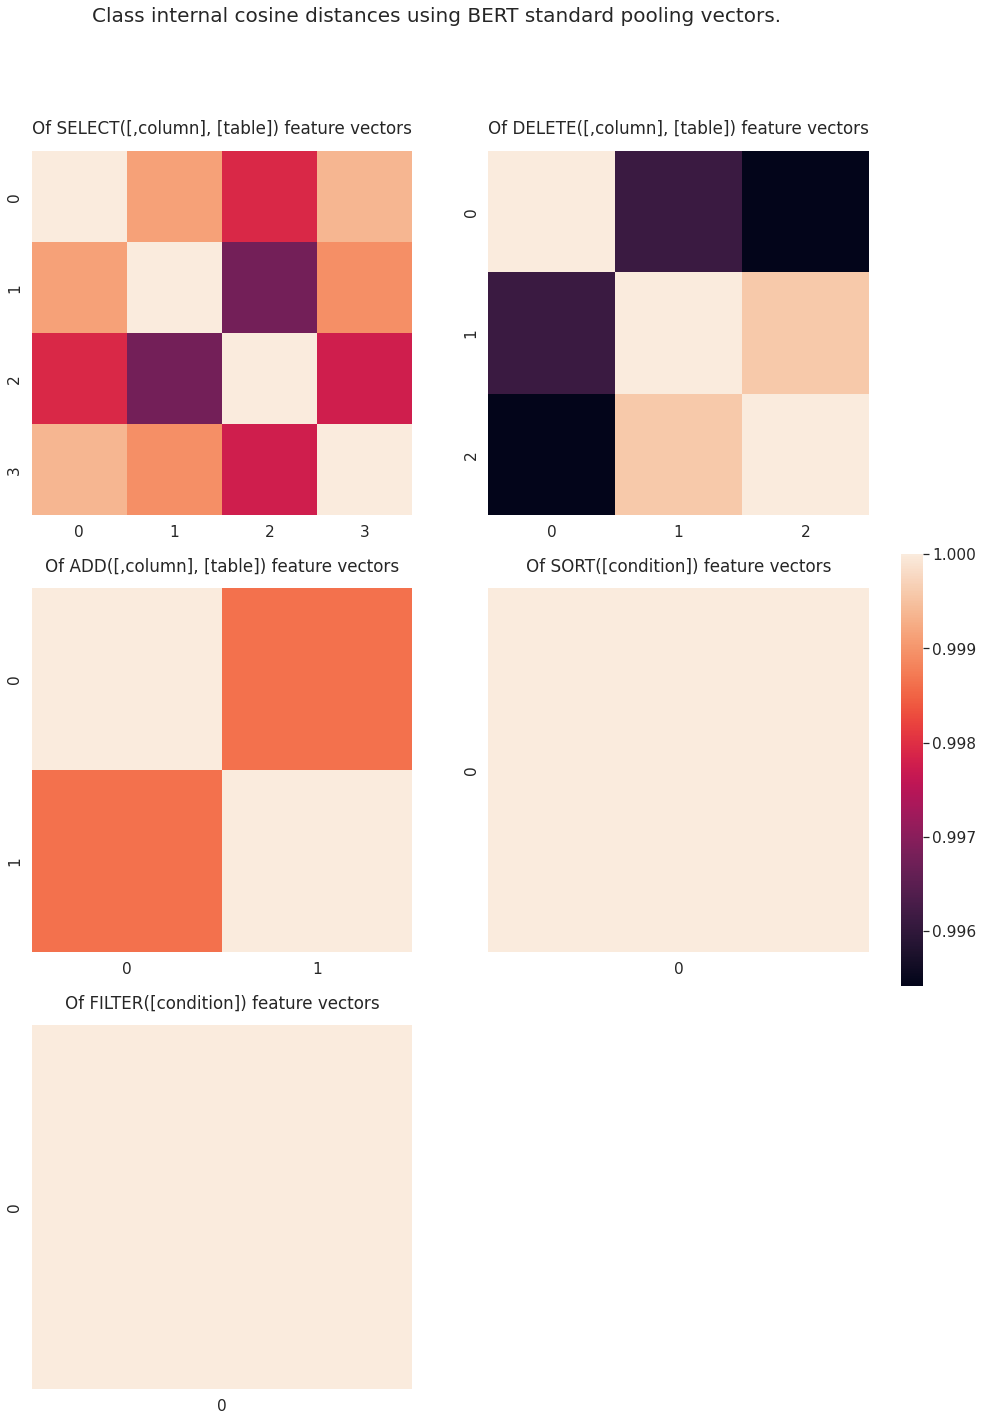

In [26]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_bert_pooling",
    class_aligned_data,
    "standard pooling dists",
    "Of {} feature vectors",
    "Class internal cosine distances using BERT standard pooling vectors.",
    hspace=0.2,
    bottom=0.02
)

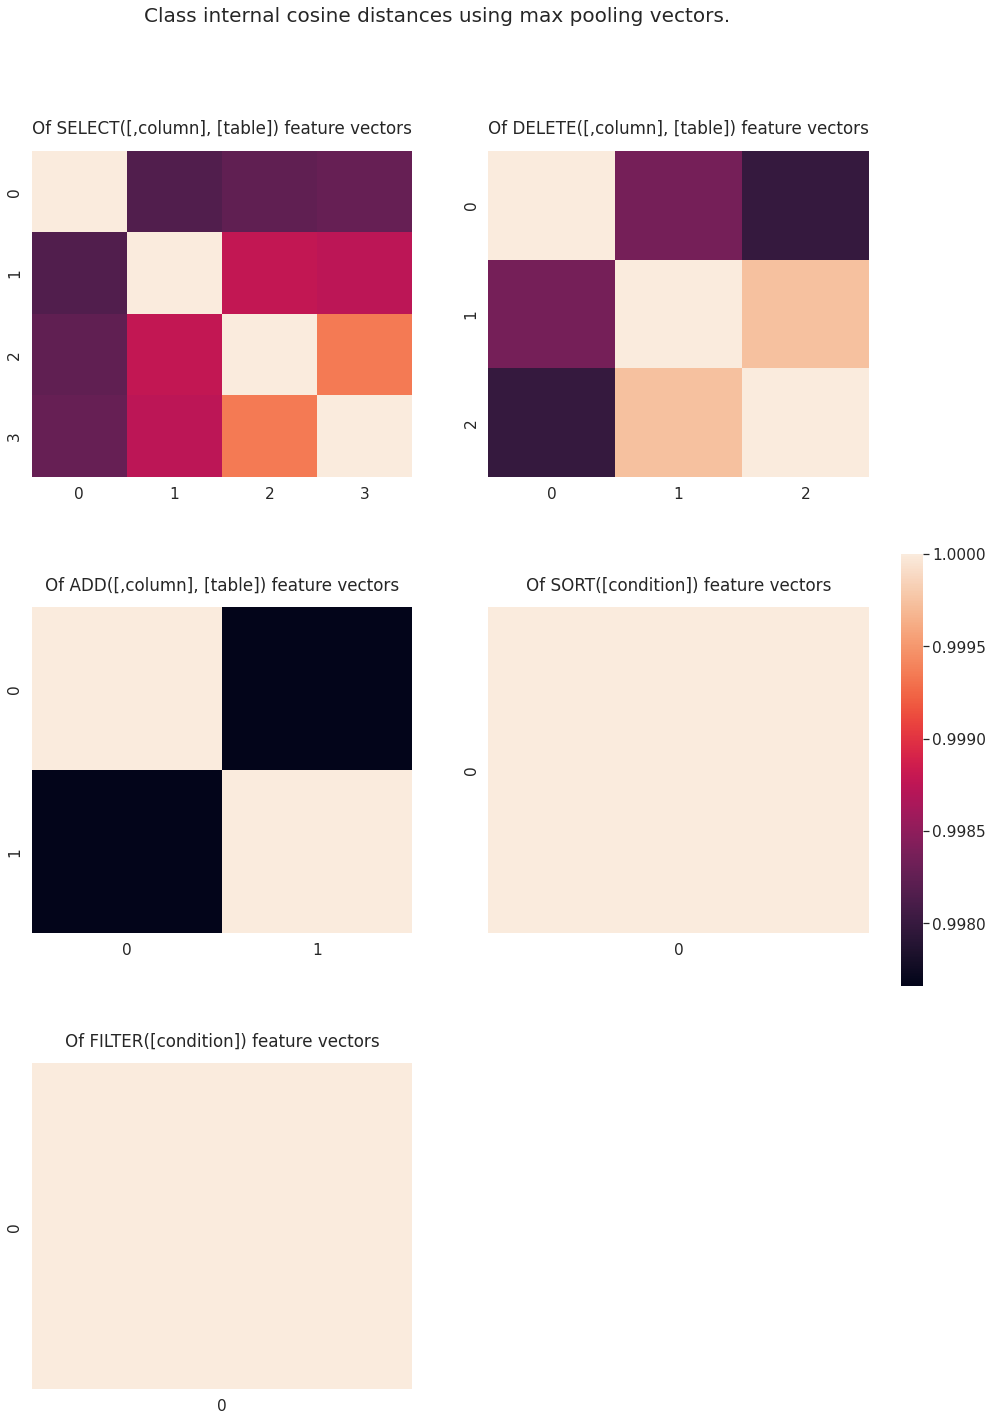

In [27]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_max_pooling",
    class_aligned_data,
    "max pooling dists",
    "Of {} feature vectors",
    "Class internal cosine distances using max pooling vectors.",
    hspace=0.4,
    bottom=0.02
)

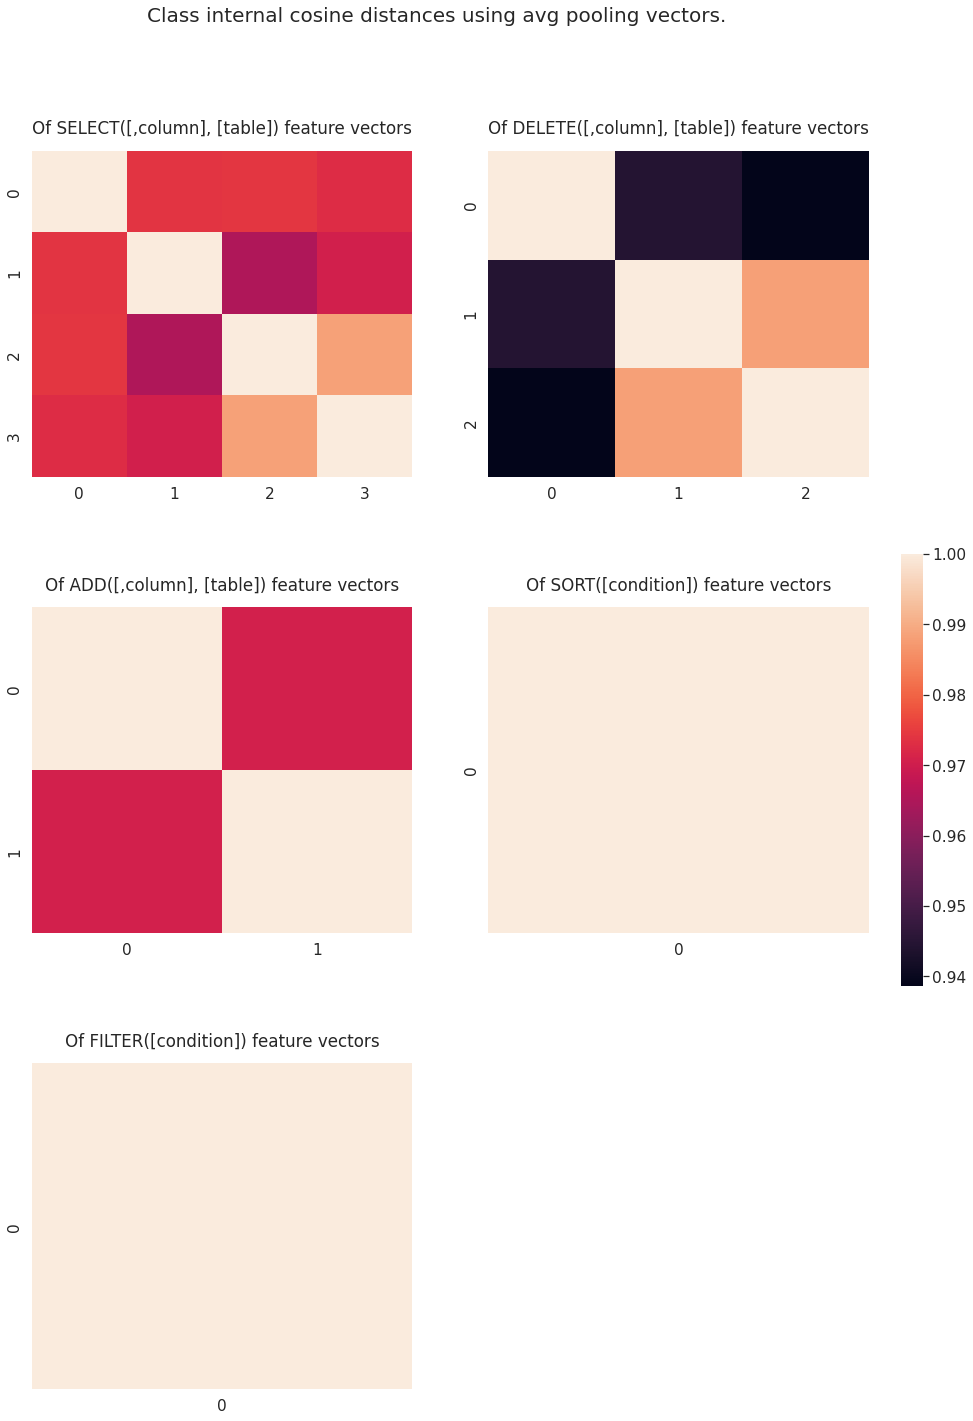

In [28]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_avg_pooling",
    class_aligned_data,
    "avg pooling dists",
    "Of {} feature vectors",
    "Class internal cosine distances using avg pooling vectors.",
    hspace=0.4,
    bottom=0.02
)

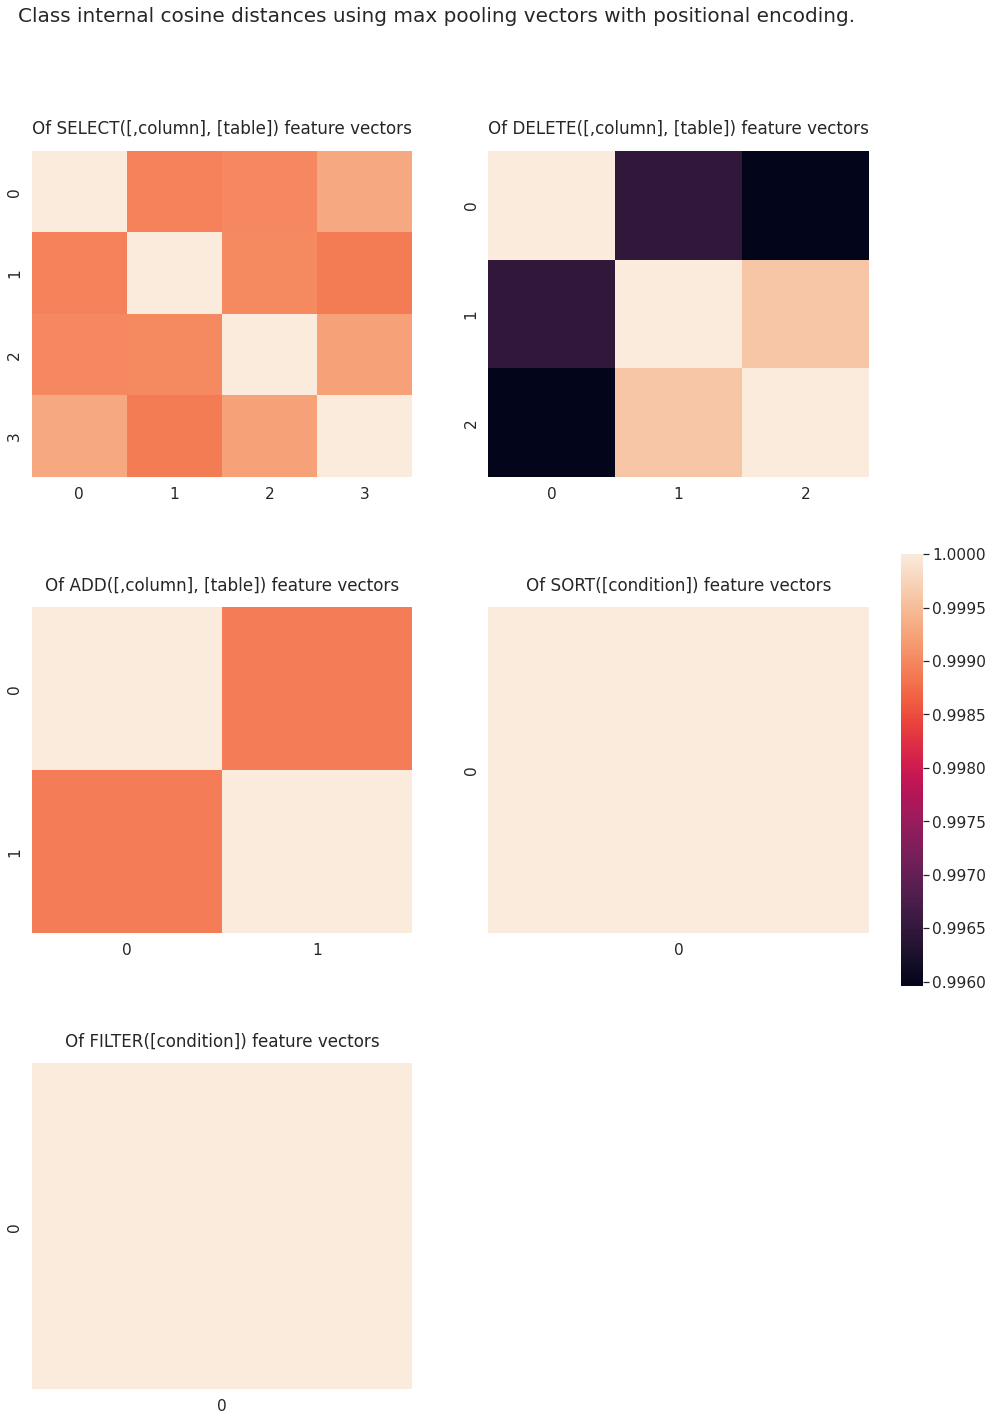

In [29]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_max_pooling_pos",
    class_aligned_data,
    "max pooling pos dists",
    "Of {} feature vectors",
    "Class internal cosine distances using max pooling vectors with positional encoding.",
    hspace=0.4,
    bottom=0.02
)

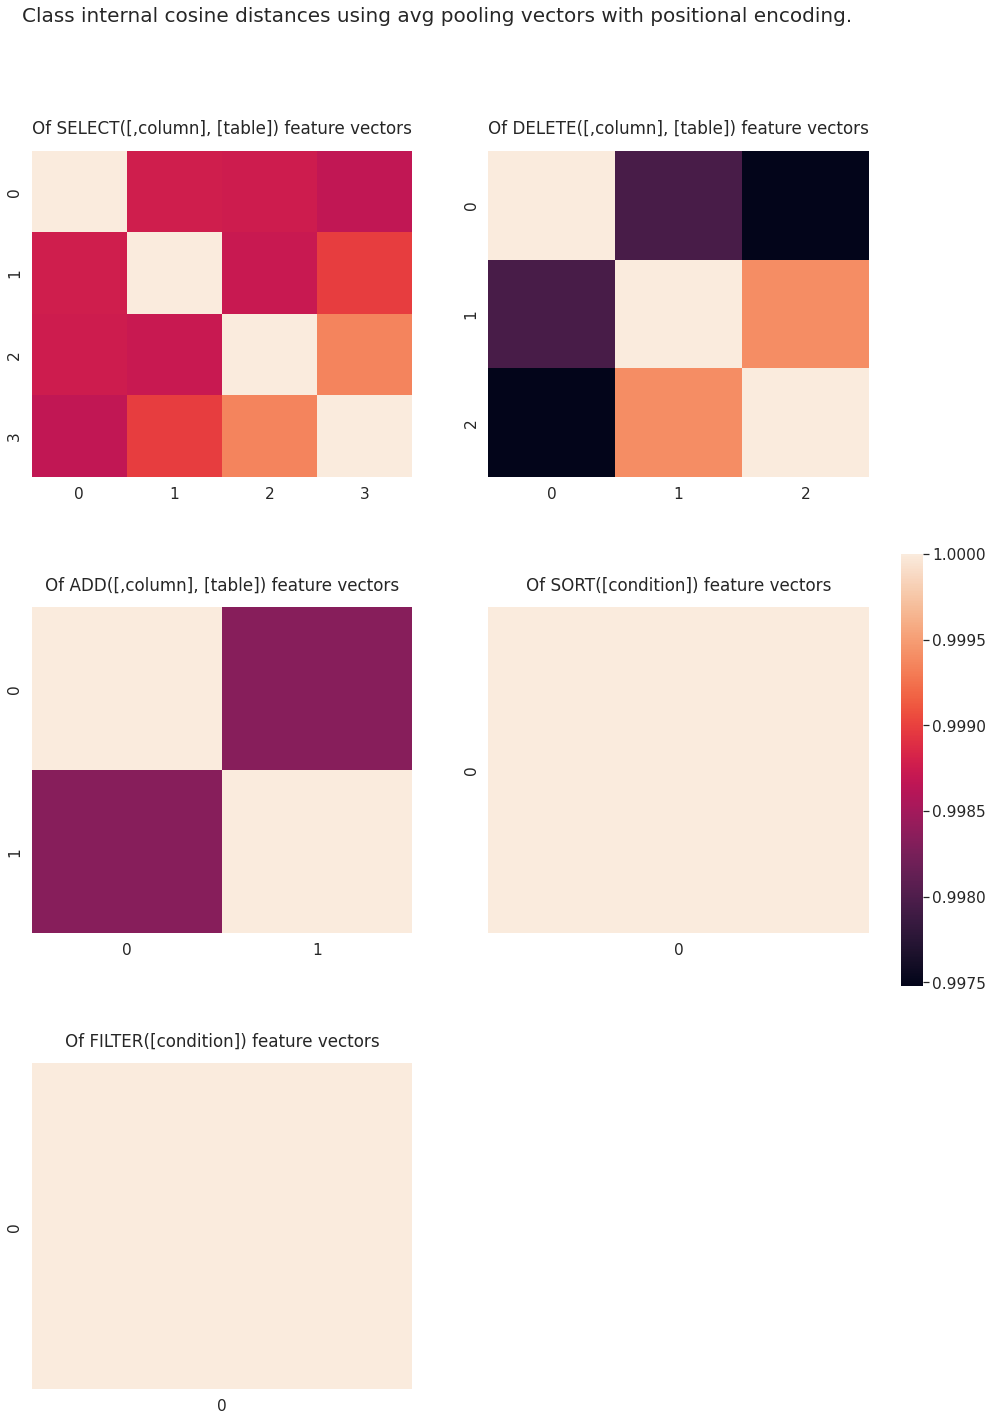

In [30]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_avg_pooling_pos",
    class_aligned_data,
    "avg pooling pos dists",
    "Of {} feature vectors",
    "Class internal cosine distances using avg pooling vectors with positional encoding.",
    hspace=0.4,
    bottom=0.02
)

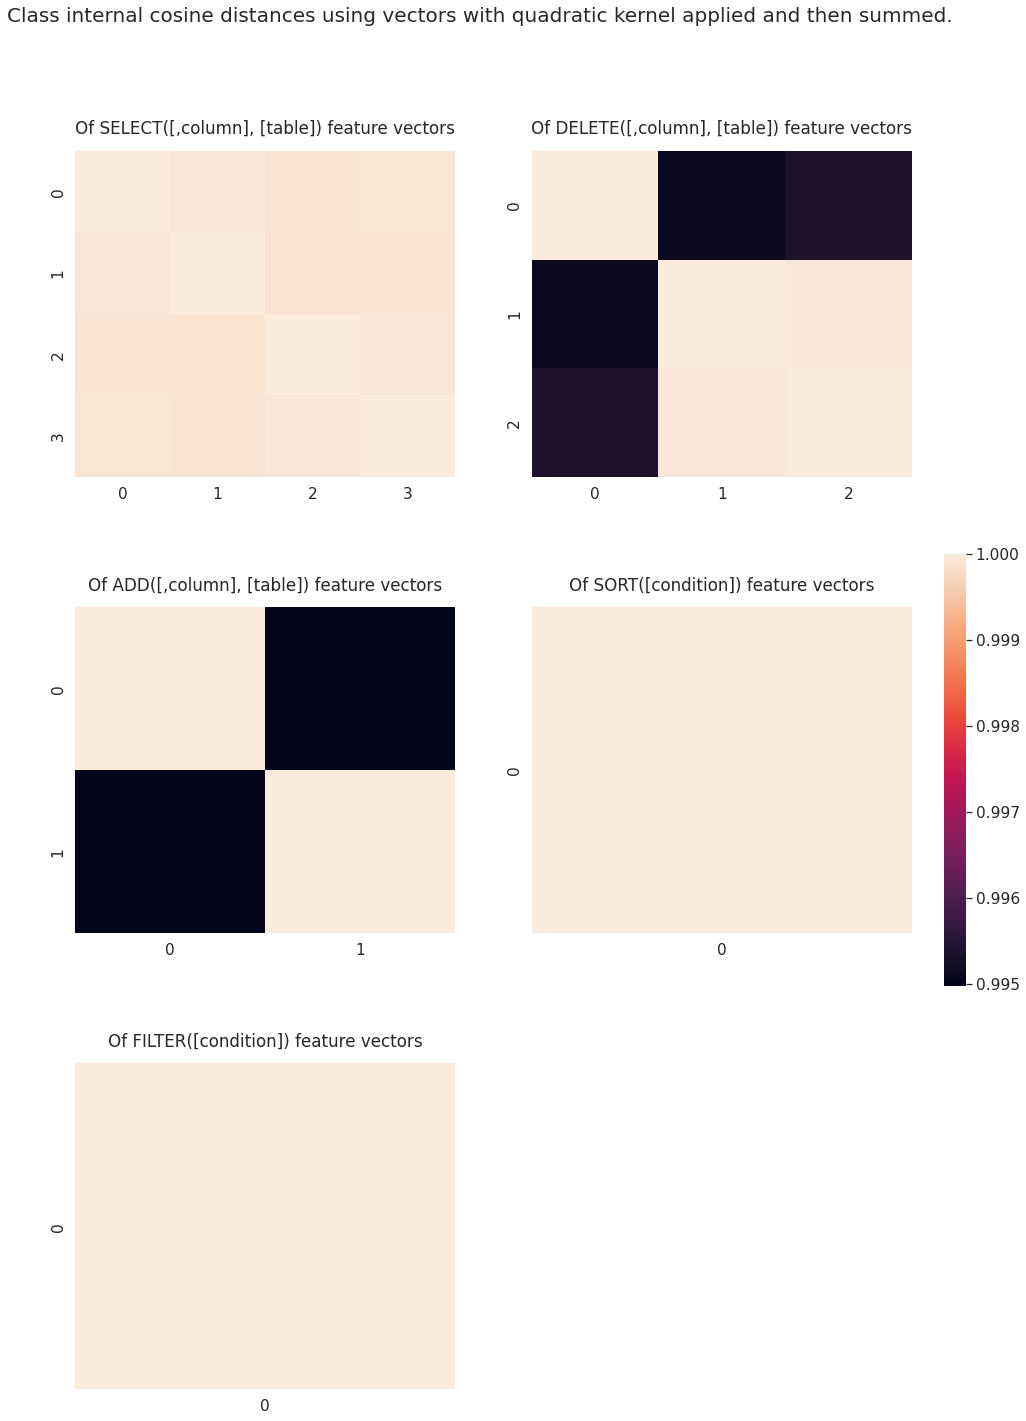

In [31]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_summed_quadratic",
    class_aligned_data,
    "sum quad kernel seq dists",
    "Of {} feature vectors",
    "Class internal cosine distances using vectors with quadratic kernel applied and then summed.",
    hspace=0.4,
    bottom=0.02
)

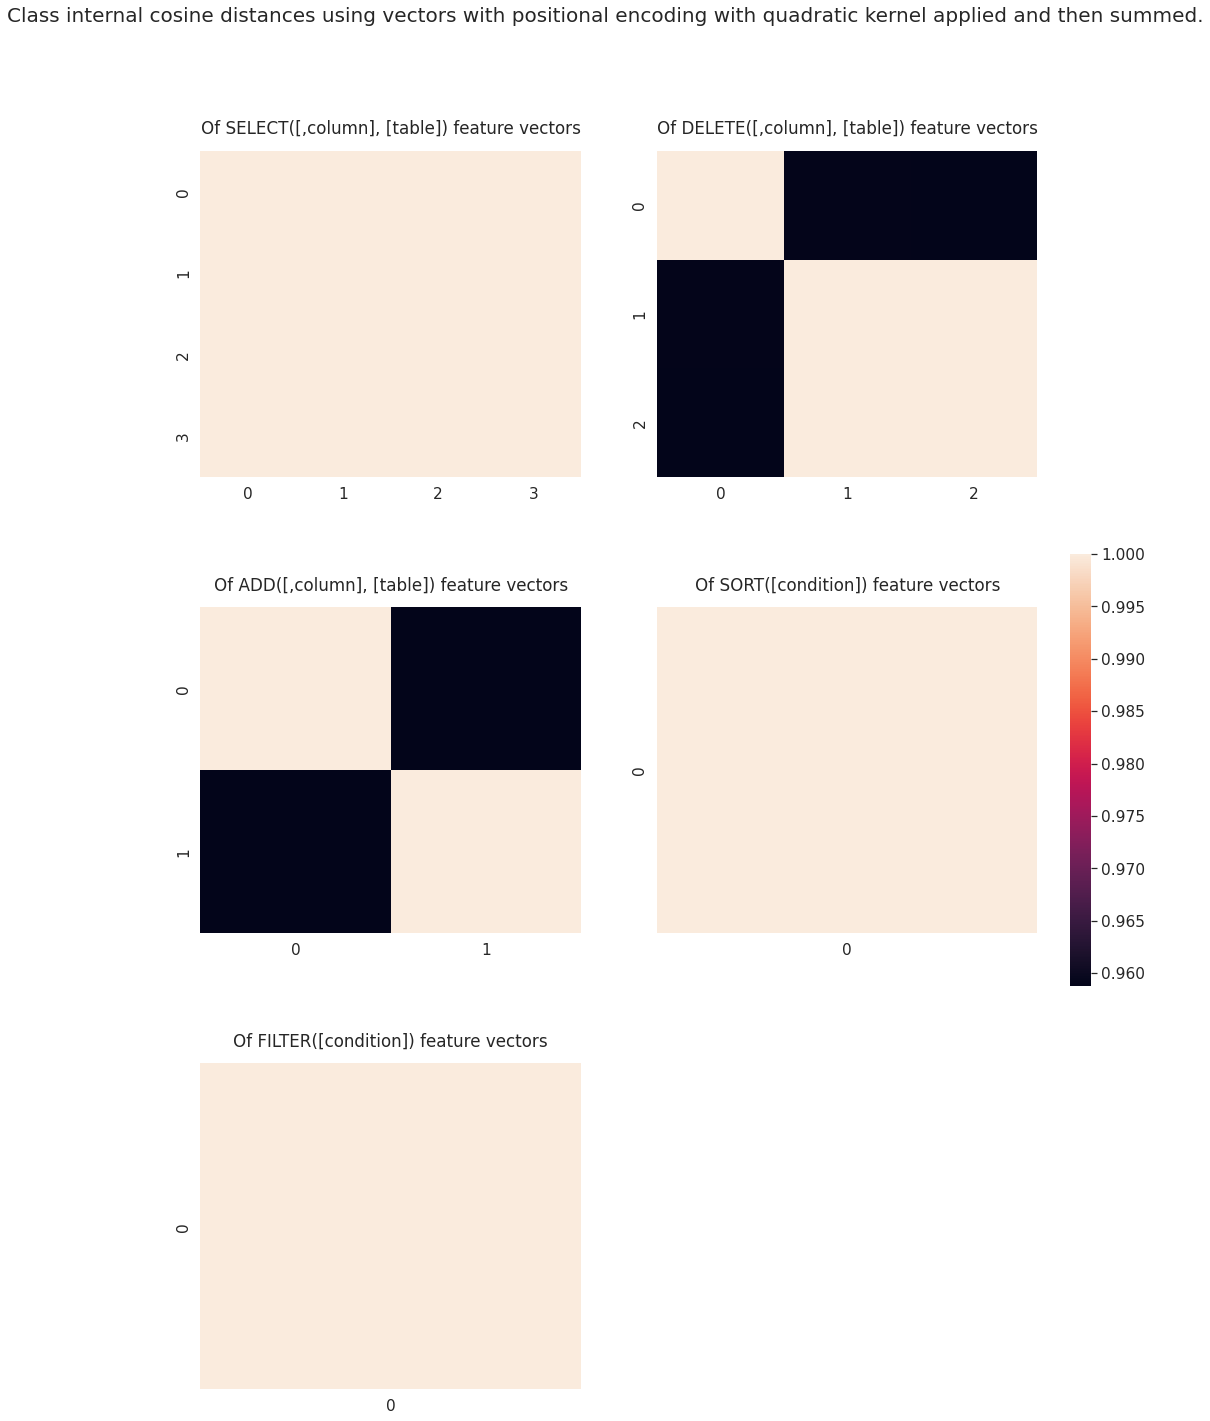

In [32]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_summed_quadratic_pos",
    class_aligned_data,
    "sum quad kernel seq pos dists",
    "Of {} feature vectors",
    "Class internal cosine distances using vectors with positional encoding with quadratic kernel applied and then summed.",
    hspace=0.4,
    bottom=0.02
)

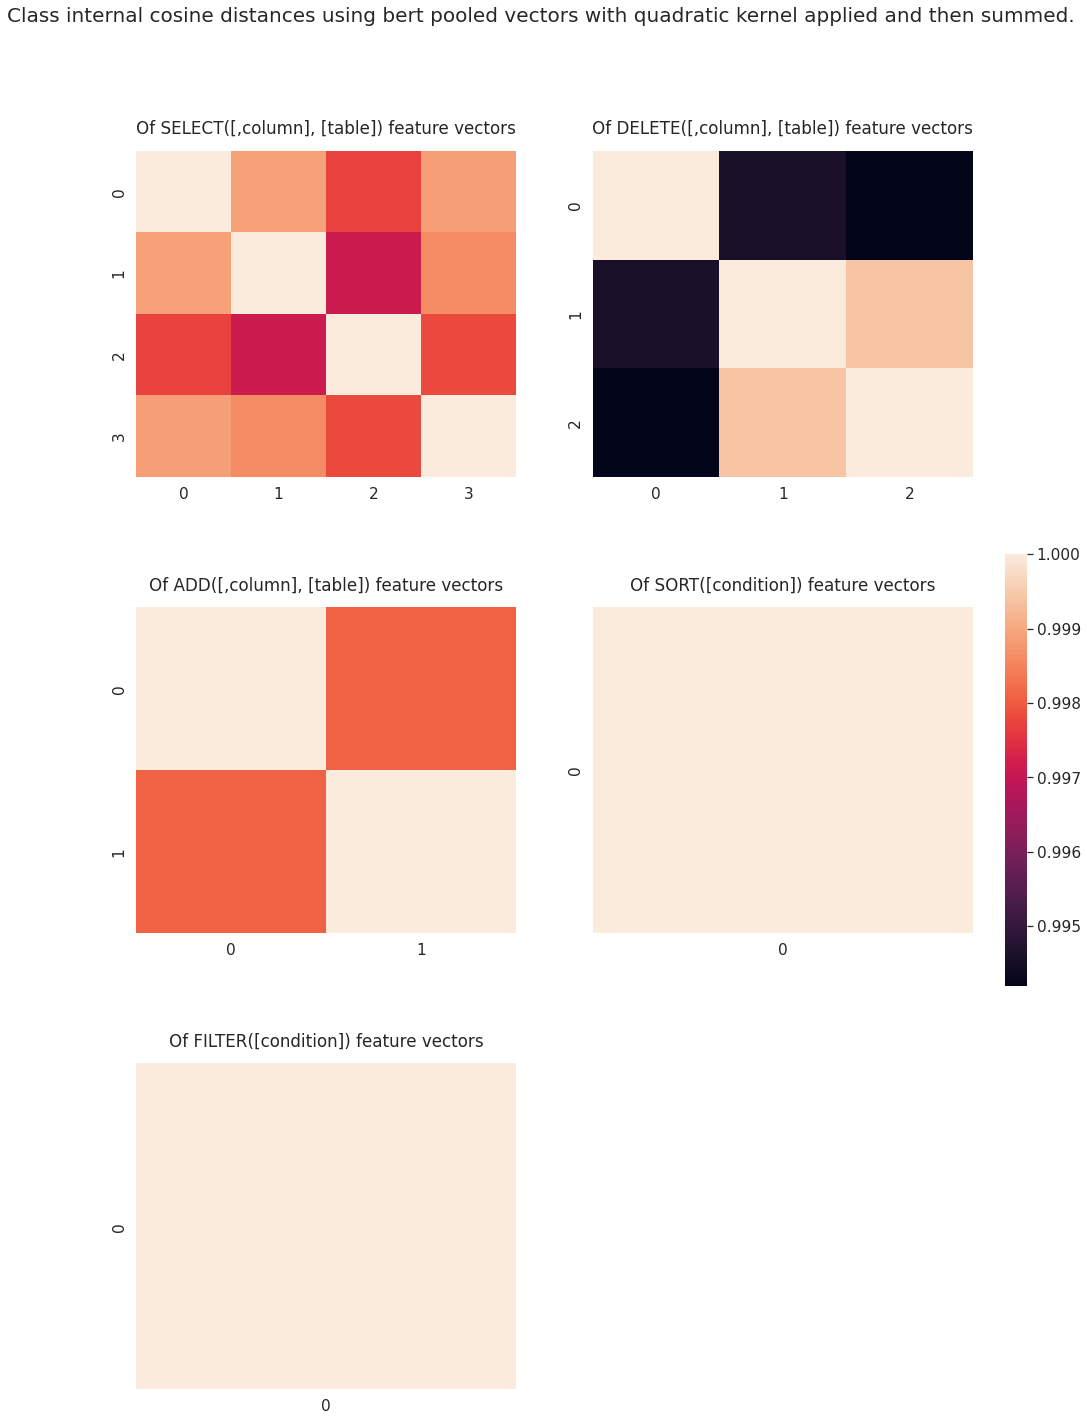

In [33]:
create_heatmaps_of_class_internal_distances(
    "cosine_class_internal_heatmap_summed_quadratic_pooling",
    class_aligned_data,
    "sum quad kernel pooling dists",
    "Of {} feature vectors",
    "Class internal cosine distances using bert pooled vectors with quadratic kernel applied and then summed.",
    hspace=0.4,
    bottom=0.02
)

## Create cosine similarity heatmap across all vectors divided by class

In [34]:
from src.plotting.plots import create_similarity_heatmap_across_all_feature_vectors_divided_by_class

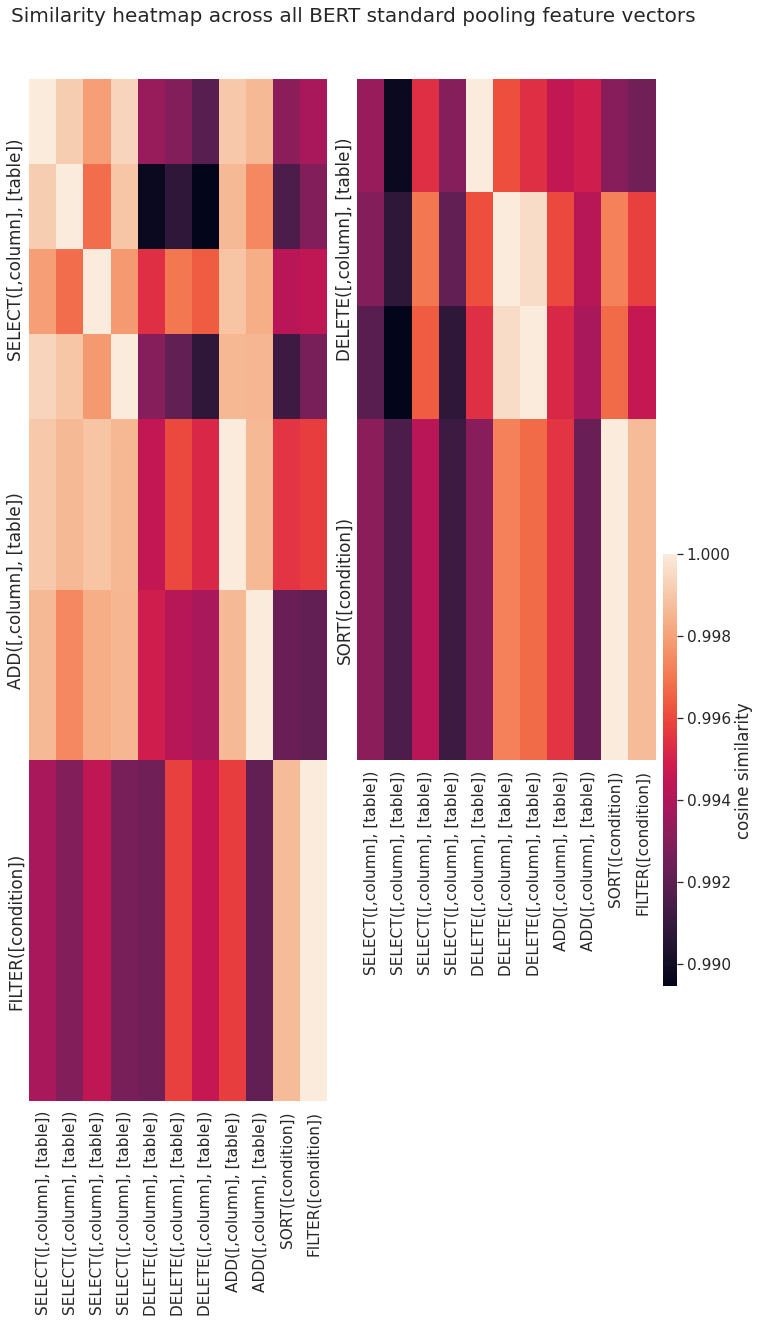

In [35]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_bert_pooling",
    class_aligned_data,
    "standard pooling",
    "Similarity heatmap across all BERT standard pooling feature vectors",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

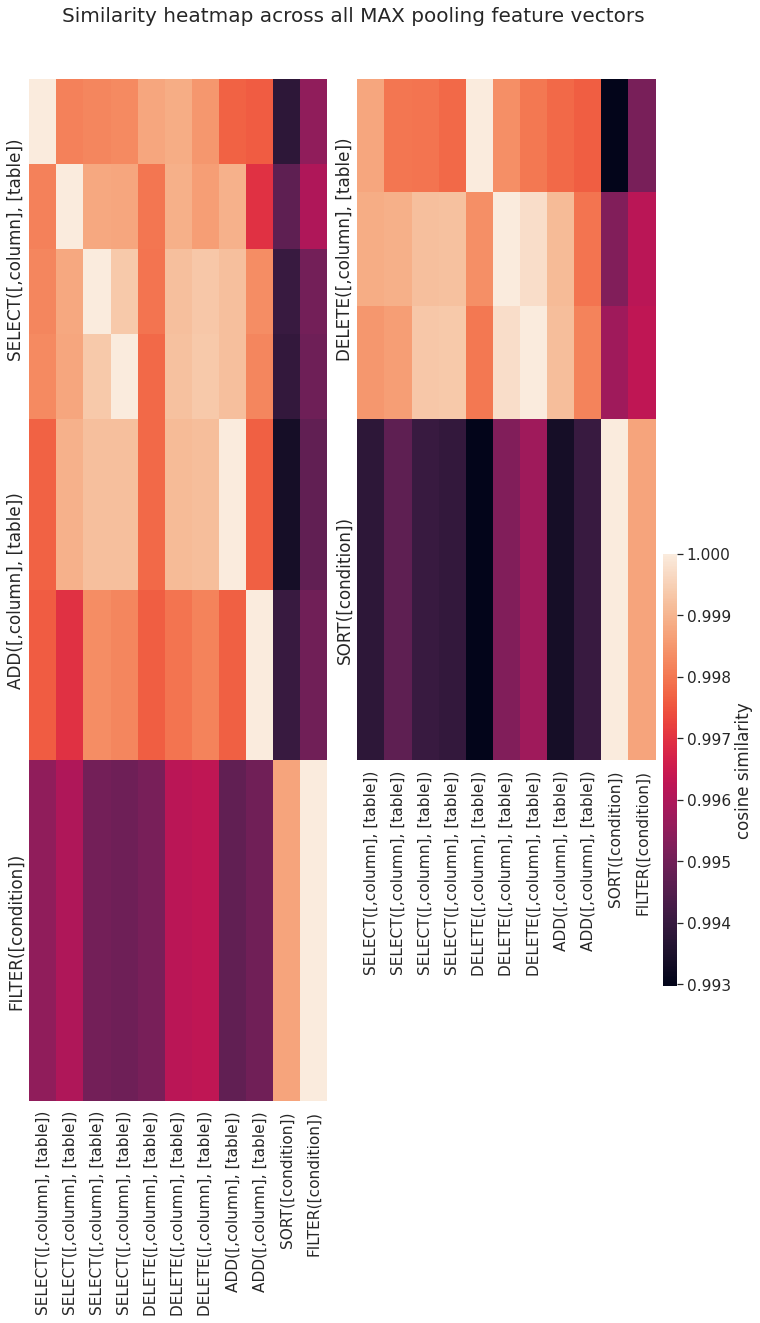

In [36]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_max_pooling",
    class_aligned_data,
    "max pooling",
    "Similarity heatmap across all MAX pooling feature vectors",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

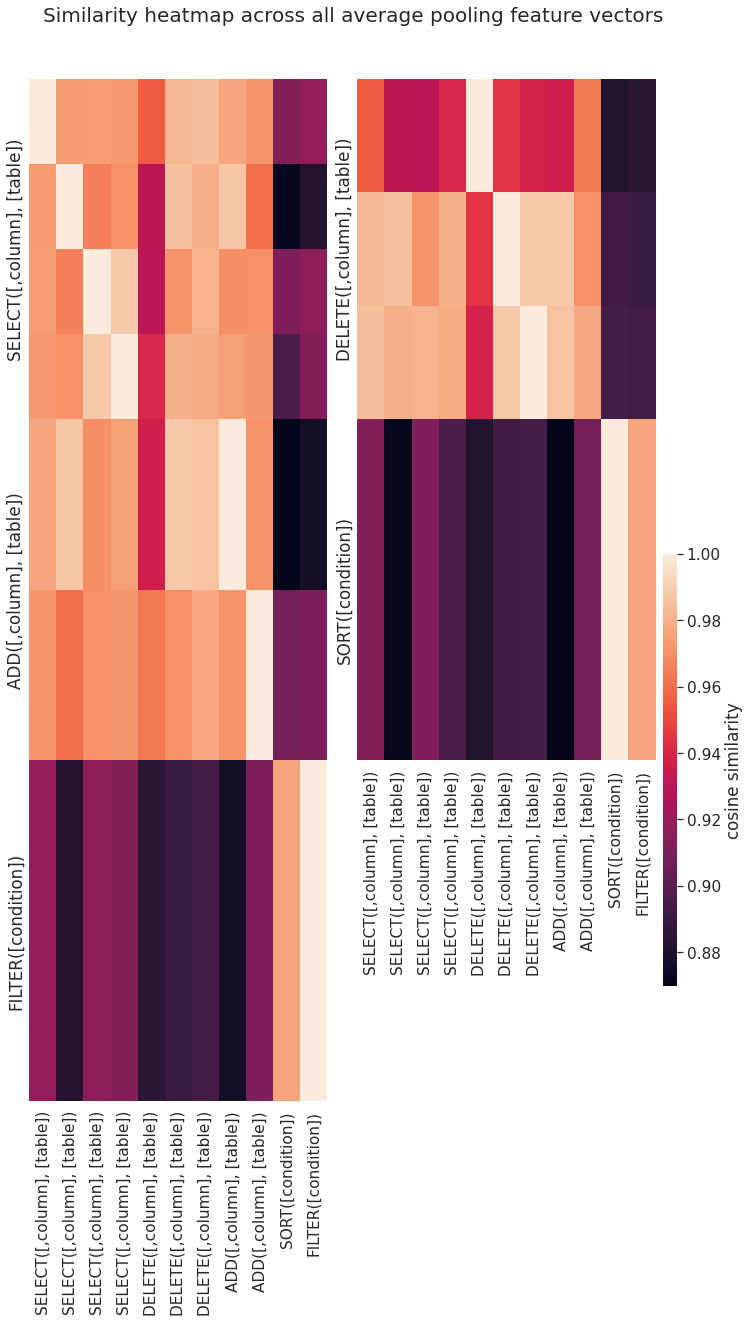

In [37]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_avg_pooling",
    class_aligned_data,
    "avg pooling",
    "Similarity heatmap across all average pooling feature vectors",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

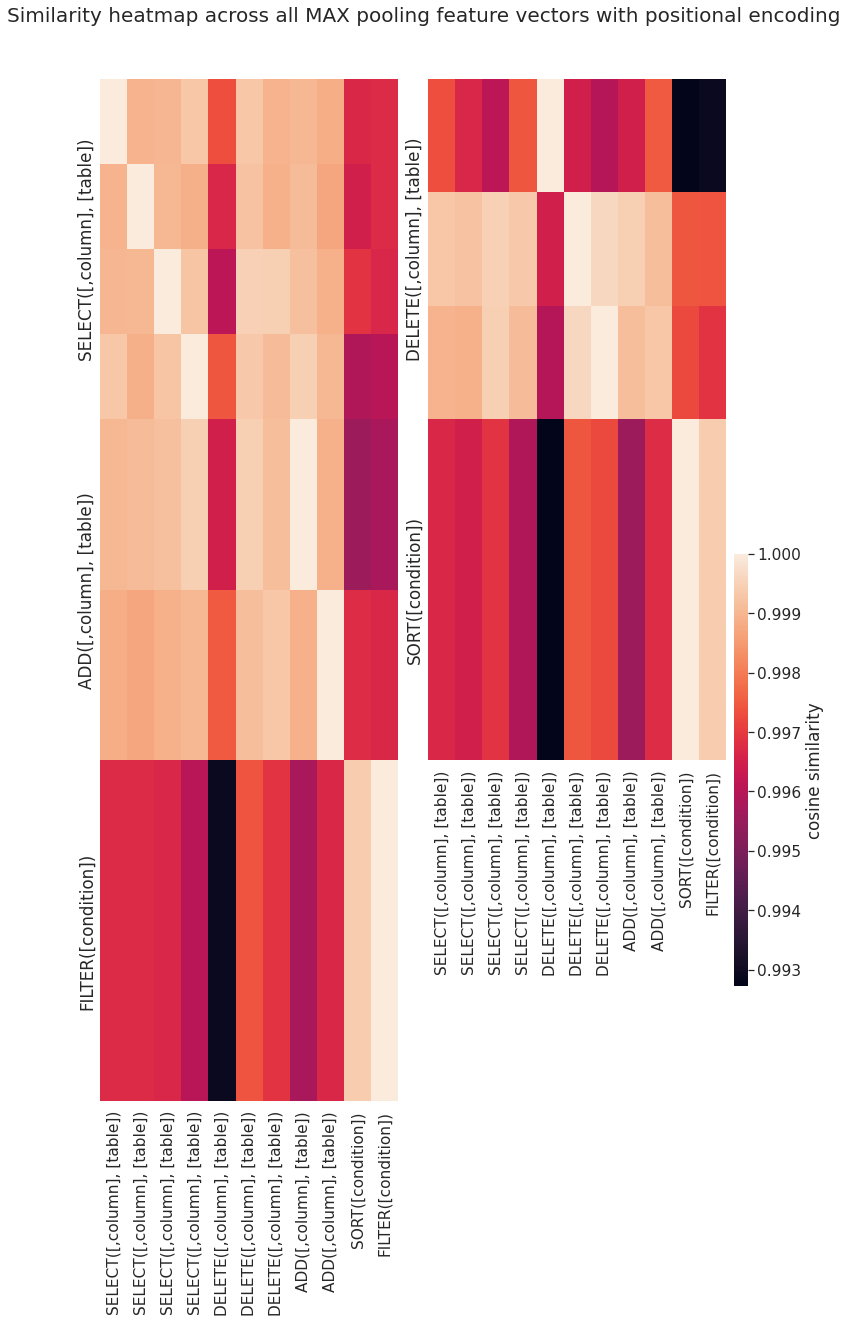

In [38]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_max_pooling_pos",
    class_aligned_data,
    "max pooling pos",
    "Similarity heatmap across all MAX pooling feature vectors with positional encoding",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

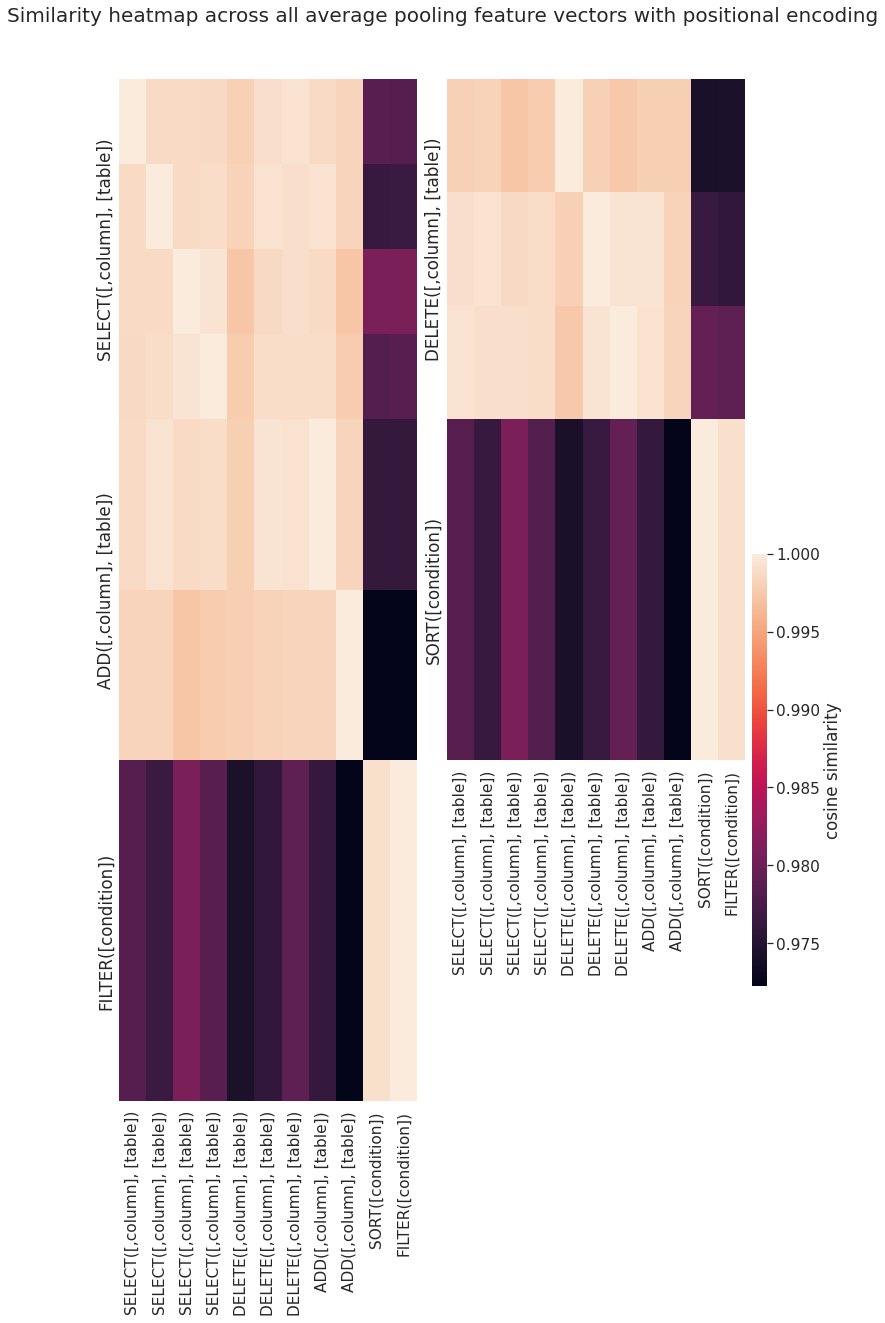

In [39]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_avg_pooling_pos",
    class_aligned_data,
    "avg pooling pos",
    "Similarity heatmap across all average pooling feature vectors with positional encoding",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

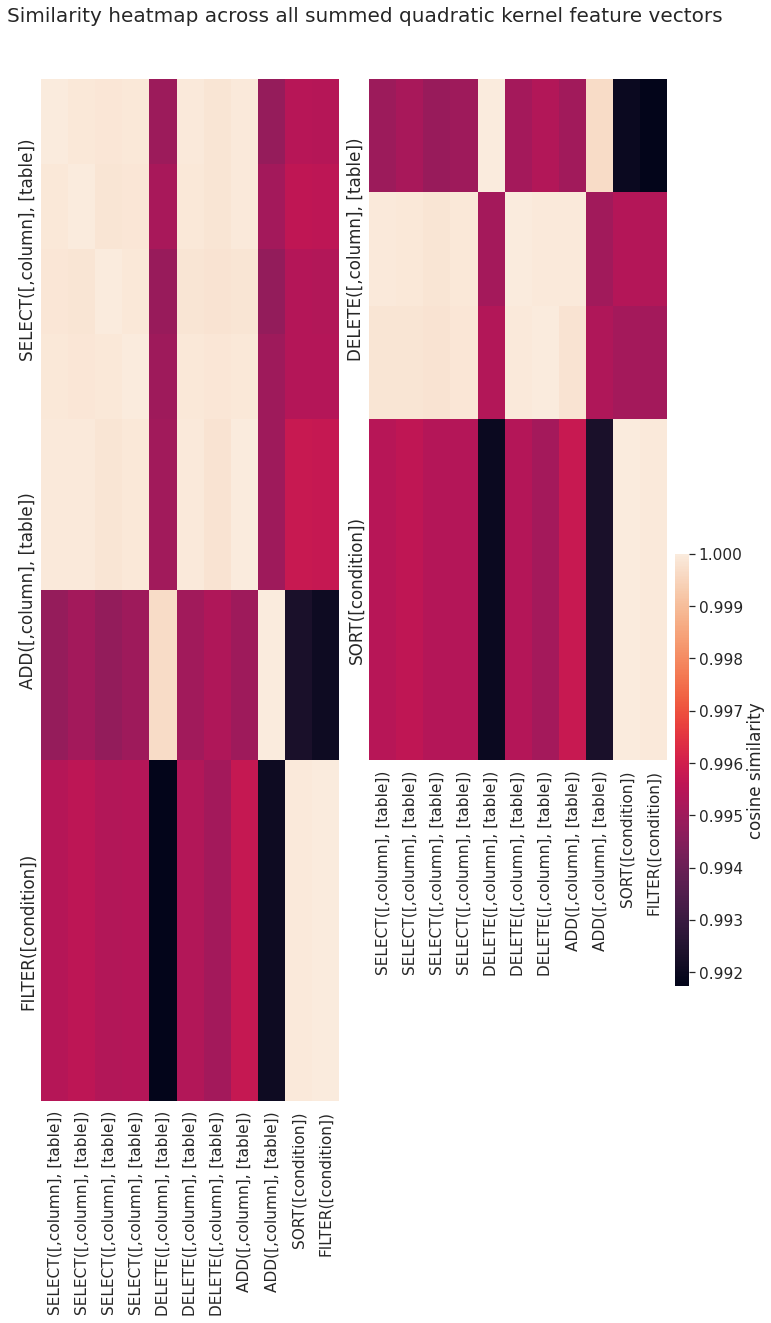

In [40]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_summed_quadratic",
    class_aligned_data,
    "sum quad kernel seq",
    "Similarity heatmap across all summed quadratic kernel feature vectors",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

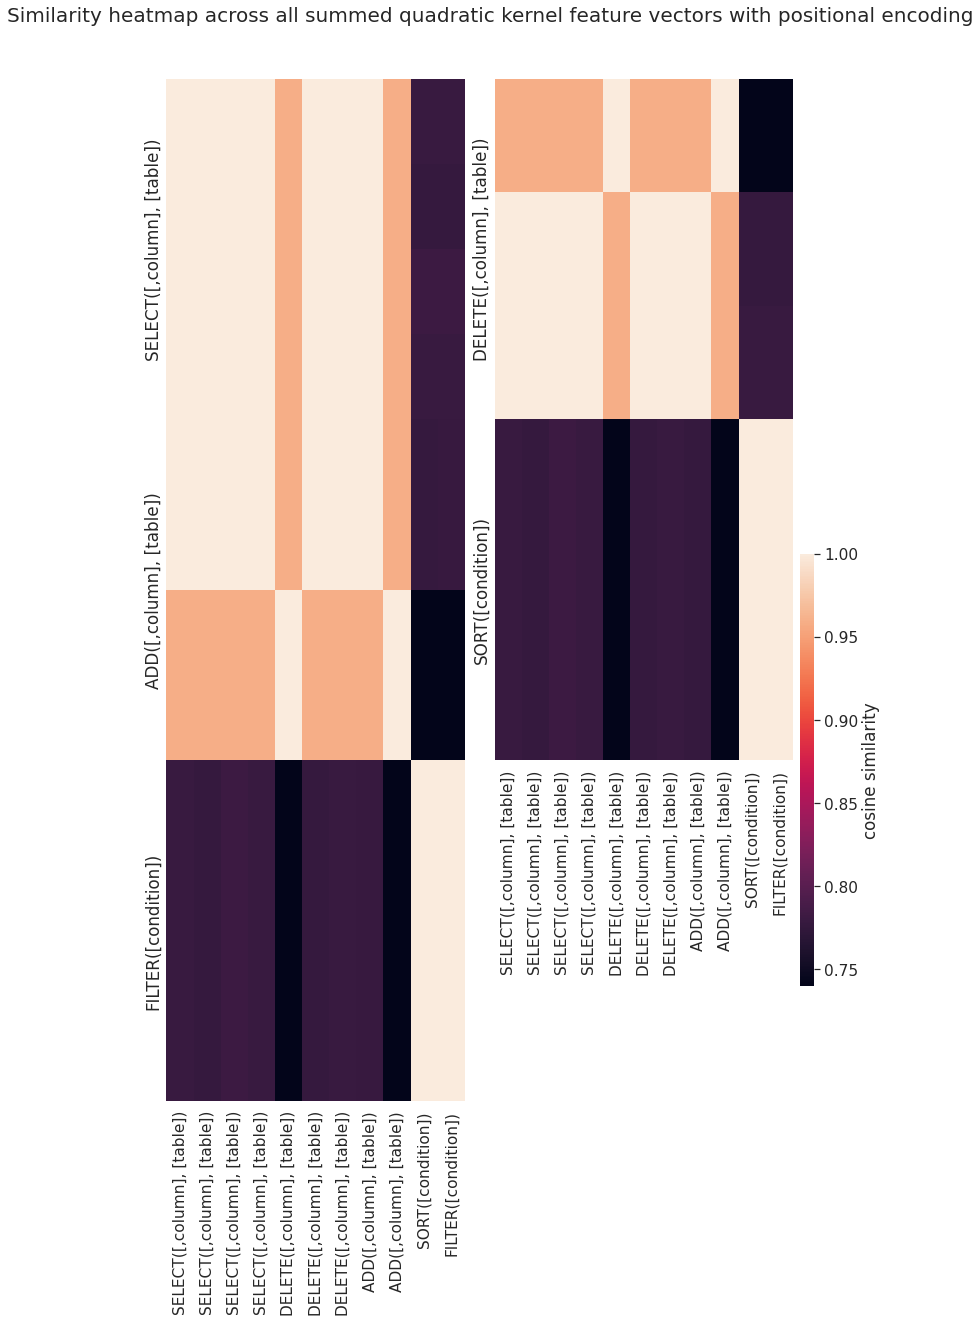

In [41]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_summed_quadratic_pos",
    class_aligned_data,
    "sum quad kernel seq pos",
    "Similarity heatmap across all summed quadratic kernel feature vectors with positional encoding",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

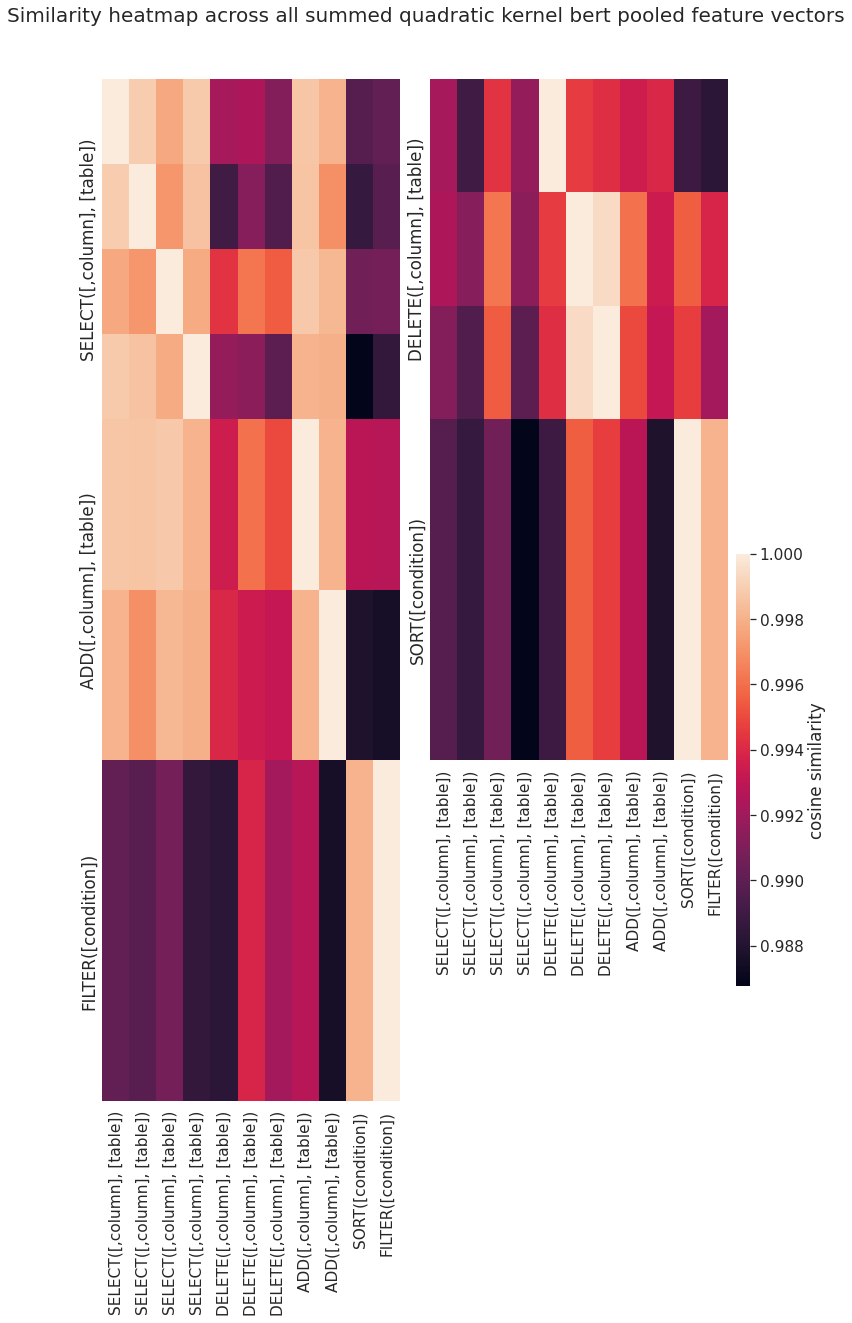

In [42]:
create_similarity_heatmap_across_all_feature_vectors_divided_by_class(
    "cosine_heatmap_divided_by_class_summed_quadratic_pooling",
    class_aligned_data,
    "sum quad kernel pooling",
    "Similarity heatmap across all summed quadratic kernel bert pooled feature vectors",
    wspace=0.1, hspace=0.0,
    left=0.05, right=0.92, top= 0.93, bottom=0.22
)

## Create histplot of distances between vectors in data set

In [43]:
from src.plotting.plots import create_distance_histplot
from src.candidate_resolver.scorers import euclidean_distance

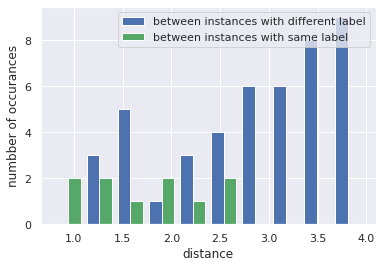

In [44]:
create_distance_histplot(
    "bert_pooling_distance_histogram",
    embedded_data, "Pooled embedding",
    "DSL output", euclidean_distance
)

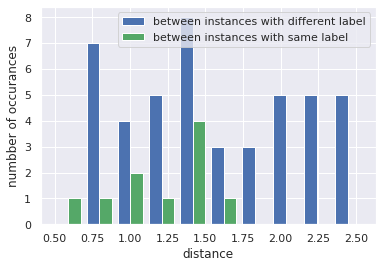

In [45]:
create_distance_histplot(
    "max_pooling_distance_histogram",
    embedded_data, "Max pooled embedding without pos",
    "DSL output", euclidean_distance
)

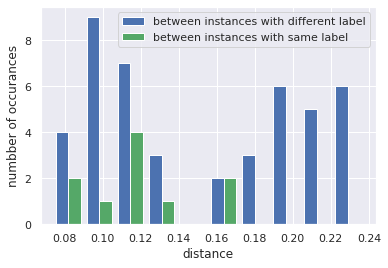

In [46]:
create_distance_histplot(
    "avg_pooling_distance_histogram",
    embedded_data, "Avg pooled embedding without pos",
    "DSL output", euclidean_distance
)

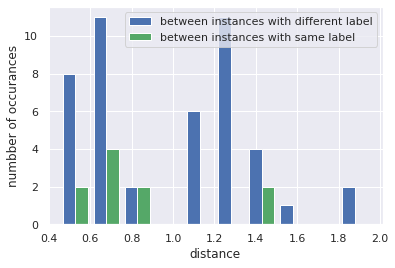

In [47]:
create_distance_histplot(
    "max_pooling_pos_distance_histogram",
    embedded_data, "Max pooled embedding with pos",
    "DSL output", euclidean_distance
)

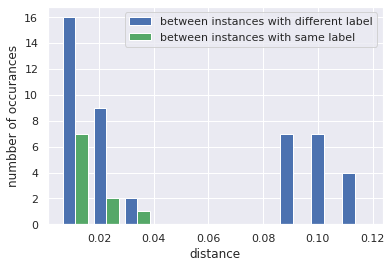

In [48]:
create_distance_histplot(
    "avg_pooling_pos_distance_histogram",
    embedded_data, "Avg pooled embedding with pos",
    "DSL output", euclidean_distance
)

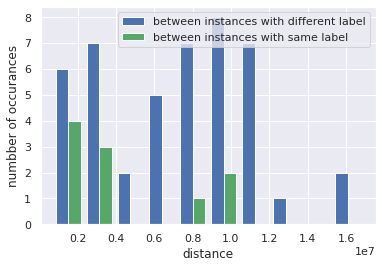

In [49]:
create_distance_histplot(
    "summed_quadratic_distance_histogram",
    embedded_data, "Summed quadratic kernel sequence embedding",
    "DSL output", euclidean_distance
)

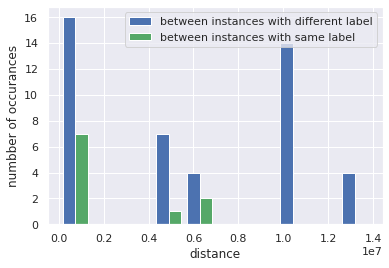

In [50]:
create_distance_histplot(
    "summed_quadratic_pos_distance_histogram",
    embedded_data, "Summed quadratic kernel sequence embedding with pos",
    "DSL output", euclidean_distance
)

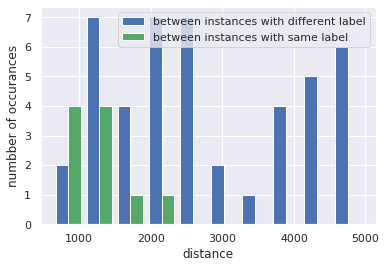

In [51]:
create_distance_histplot(
    "summed_quadratic_pooling_distance_histogram",
    embedded_data, "Summed quadratic kernel pooled embedding",
    "DSL output", euclidean_distance
)